In [177]:
import os
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.stats
from IPython.parallel import Client
from scipy.stats import norm
from scipy.stats import beta
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os.path as op
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [2]:
rc = Client() #only do this once

# First let's pull some choice data from the experiment

In [3]:
home_dir = '/home/iballard/Dropbox/Magnitude_fMRI/'
experiment_data = pd.read_csv(home_dir + 'subj_params.csv')
data = experiment_data[experiment_data['sub'] == 'subject03']
data = data[data['HL'] == 'low']
data = data[['amountLL','amountSS','delayLL','delaySS']] #clean up

In [4]:
fit_params = pd.read_csv(home_dir + '/model_fits.csv')
fit_params.median()


LL_high     8.860504
LL_low     11.316190
k_high      0.000720
k_low       0.013172
m_high      0.058333
m_low       1.226477
dtype: float64

# Now let's define some key functions for the hyperbolic model and model fitting

In [5]:
def flip(p):
    return 'SS' if rd.random() < p else 'LL'

In [6]:
def hyperbolic(A,d,k):
    return A * 1.0/(1.0+k*7*d)

In [7]:
def run_simulation(params,sub_df):
    k,m = params
    choices = []
    for i in range(sub_df.shape[0]):
        SV_SS = hyperbolic(sub_df.loc[i,'amountSS'],
                            sub_df.loc[i,'delaySS'],
                            k)
        SV_LL = hyperbolic(sub_df.loc[i,'amountLL'],
                            sub_df.loc[i,'delayLL'],
                            k)
        p = 1 / (1 + np.exp(-1*m*(SV_SS-SV_LL)) )
        choices.append(flip(p))
        
    return choices

In [8]:
def get_LL(params,sub_df):
    k,m = params
    LL = 0
    for i in range(sub_df.shape[0]):
        SV_SS = hyperbolic(sub_df.loc[i,'amountSS'],
                            sub_df.loc[i,'delaySS'],
                            k)
        SV_LL = hyperbolic(sub_df.loc[i,'amountLL'],
                            sub_df.loc[i,'delayLL'],
                            k)

        p = 1 / (1 + np.exp(-1*m*(SV_SS-SV_LL)) )

        if sub_df.loc[i,'choice'] == 'LL':
            p = 1-p
        LL += np.log(p)
    return -1*LL

# Visualize likelihood energy function for choices around a typical k,m

In [9]:
ks = np.linspace(.005,.025,41) 
ms = np.linspace(.5,3,41)
LL = []
k_idx = []
m_idx = []

#simulate data
params = (.015,1.23)
data['choice'] = run_simulation(params,data)

#get LL for other ks, ms
for m in ms:
    for k in ks:
        LL.append(get_LL((k,m),data))
        k_idx.append(k)
        m_idx.append(m)  
df = pd.DataFrame({'ks':k_idx,'LL':LL, 'm':m_idx})

In [15]:
df['LL'] = df['LL']*-1

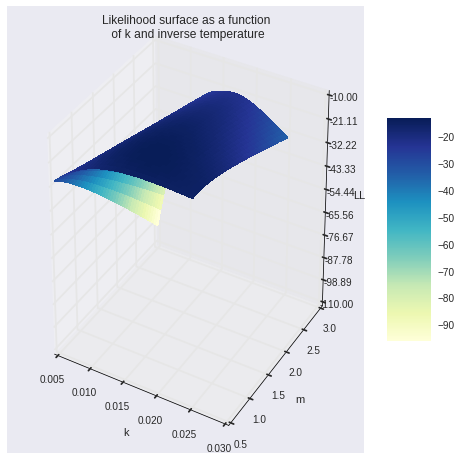

In [101]:
#plot likelihood surface
fig = plt.figure(figsize = (8,8))
plt.set_cmap('Blues')
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(ks, ms)
Z = np.array([float(df[(df['ks'] == x) & (df['m'] == y)]['LL']) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
plt.xlabel('k')
plt.ylabel('m')
ax.set_zlabel('LL')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.YlGnBu,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=.5, aspect=5)
plt.title('Likelihood surface as a function \n of k and inverse temperature')
plt.show()

The energy function is well-behaved in the k dimension: it shows a monotonically decreasing function around the global maximum. In the m dimension, the function is much flatter, which reflects the fact that a wider range of m's provide a similar account of choice data. This makes sense because m is unbounded for noiseless responding. Importantly, there does not appear to be a trade-off between k and m (which would be evident as a long, diagonal basin of attraction around the global maximum. This would be a problem because it suggests that only slightly different data could have resulted in very different ML estimates.

In [178]:
df[df['LL'] == max(df['LL'])]

,LL,ks,m
311,-12.837565,0.017,0.9375


The maximum of this function is close to the true k, but not very close to the true m

# Next let's determine how wrong we can expect to be about k and m

We need a function to sample paramters from a normal distribution with mean and variance matching that of our empirical sample

In [179]:
def get_k_and_m():
    k = np.random.normal(fit_params['k_low'].median(),
                 fit_params['k_low'].std())
    m = np.random.normal(fit_params['m_low'].median(),
                 fit_params['m_low'].std()) 
    if k < 0 or m < 0:
        return get_k_and_m()
    
    return k,m

These functions sample parameters, simulate choices on our choice set, infer k and m from those choices, and save the result

In [13]:
def compare_k_and_m(x):
    k,m = get_k_and_m()
    data['choice'] = run_simulation((k,m),data)

    bounds = ((0,1),(0,30))
    minimizer_kwargs = {"method": "SLSQP",'bounds':bounds, 'args':data}
    res = scipy.optimize.minimize(get_LL, (.01,.01),bounds = bounds, args=data, method = 'BFGS') 
    k_hat,m_hat = res.x

    out_f  = op.abspath('simulation/' + str(k) + '.txt')
    np.savetxt(out_f,[k,m,k_hat,m_hat])
    return

In [23]:
dview = rc[1:50] 
dview.block=True
dview.push(dict(get_k_and_m=get_k_and_m,
                data = data,
                run_simulation = run_simulation,
                hyperbolic = hyperbolic,
                get_LL = get_LL,
                fit_params = fit_params, 
                flip = flip))
dview.execute('import numpy as np') 
dview.execute('import random as rd') 
dview.execute('import os.path as op') 
with dview.sync_imports():
    import os
    from pandas import DataFrame, Series
    import scipy
    import scipy.stats
    
#run
in_str = 10000*[0] #10,000 simulation runs
output = dview.map_sync(compare_k_and_m,in_str) 

importing os on engine(s)
importing DataFrame,Series from pandas on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)


Next let's load the cached results

In [164]:
sim_results = glob.glob(op.abspath('simulation/*txt'))
sim_df = {'k':[],'m':[],'k_hat':[],'m_hat':[]}
for r in sim_results:
    k,m,k_hat,m_hat = np.loadtxt(r)
    if k_hat < 1 and k_hat > 0 and m_hat > 0:
        sim_df['k'].append(k)
        sim_df['m'].append(m)
        sim_df['k_hat'].append(k_hat)
        sim_df['m_hat'].append(m_hat)
sim_df = pd.DataFrame(sim_df)

In [197]:
#compute error
sim_df['k_diff'] = sim_df['k'] - sim_df['k_hat']
sim_df['m_diff'] = sim_df['m'] - sim_df['m_hat']

#normalize by population standard deviation
sim_df['k_diff'] = sim_df['k_diff'] / fit_params.std()['k_low']
sim_df['m_diff'] = sim_df['m_diff'] / fit_params.std()['m_low']

#drop extremes for visualization purposes
sim_df['k_diff_abs'] = map(abs,sim_df['k_diff'])
trimmed = sim_df[sim_df['k_diff_abs'] <1]
print 'percent of extreme (greater than 1 SD) ks',100*(1 - trimmed.shape[0]*1.0/sim_df.shape[0])

percent of extreme (greater than 1 SD) ks 1.64326573063


First let's look at how far off our k estimates were

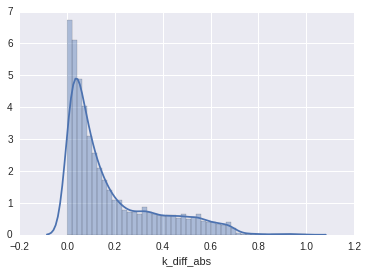

In [188]:
sns.distplot(trimmed['k_diff_abs'])

We have some error in our estimates, but it is small. The bulk of our estimates are within .2 of our between-subject standard deviation. This should give us some confidence that it is reasonable to look at covariates of k across subjects.

Noisier subjects should be harder to estimate. Next, let's examine the relationship between inverse temperature and our error in k.

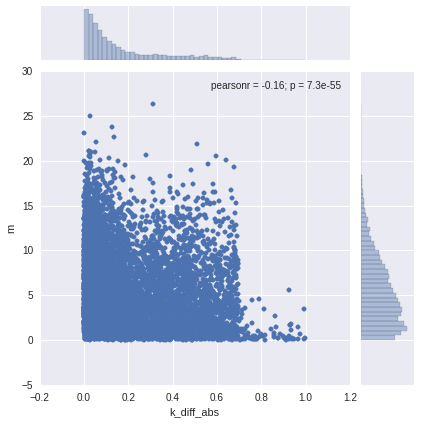

In [187]:
sns.jointplot('k_diff_abs', 'm', data = trimmed)

Indeed, our uncertainty around k increases substantially for noisier subjects

There is not much we can do about estimating noisier subjects more reliably. Given that our overall confidence in our estimates is fairly high, the best we can do is conduct well-powered studies. A remaining concern is that noisier subjects have biased estimate of discount rate. So far we have only looked at the absolute value of the error. Next, let's see if there is a relationship between choice noise and the direction of the error in k.

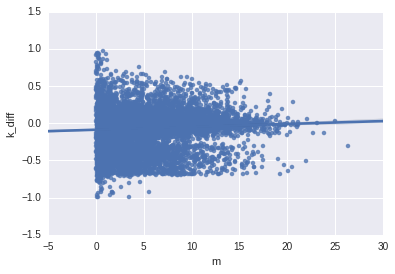

In [190]:
ax = sns.regplot(x="m", y="k_diff", data=trimmed)

There appears to be a relationship. Next let's test whether it's reliable

In [191]:
trimmed['m_norm'] = trimmed['m'] / fit_params.std()['m_low'] #change units to population SD
results = smf.ols('k_diff ~ m_norm ', data=trimmed).fit()
print results.summary()


                            OLS Regression Results                            
Dep. Variable:                 k_diff   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     35.76
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           2.32e-09
Time:                        11:33:32   Log-Likelihood:                -262.78
No. Observations:                9457   AIC:                             529.6
Df Residuals:                    9455   BIC:                             543.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0877      0.004    -20.002      0.0

Noisier subjects have significantly greater k (that is, there is a bias towards estimating noisier subjects as being more impulsive than they are). However, this relationship is tiny: a change of one population standard deviation in m causes an increase of .02 standard deviations of k. For most studies, this bias should be too small to have any meaningful effect.

Very impulsive or very impatient subjects will have mostly larger later or mostly smaller sooner choices. In these cases, it will be hard to estimate k. Let's see this in the data.

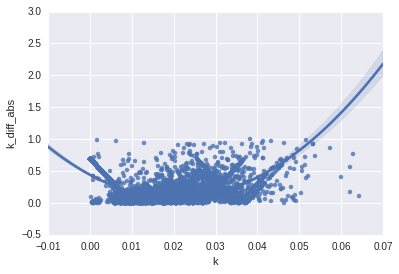

In [203]:
sns.regplot(x ='k',y = 'k_diff_abs', order = 2, data = trimmed)

As you can see, there is increasing error for extreme values of k. It is worth checking to make sure that your results are not driven by subjects in this extreme range, as their model fits are less likely to be accurate.

Finally, let's examine the reliability of m. We expect it to be worse than k given the likelihood surface

In [195]:
sim_df['m_diff_abs'] = map(abs,sim_df['m_diff'])
trimmed = sim_df[sim_df['m_diff_abs'] <1]
print 'percent of extreme (greater than 1 SD) ms',100*(1 - trimmed.shape[0]*1.0/sim_df.shape[0])

percent of extreme (greater than 1 SD) ms 51.0036401456


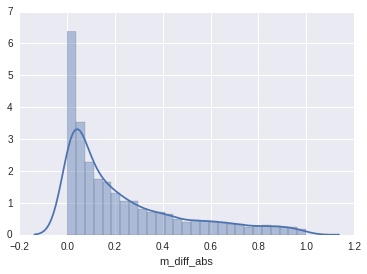

In [196]:
sns.distplot(trimmed['m_diff_abs'])

More than half of estimates are more than 1 standard deviation from the true balue. Strong conclusions should not be drawn about the temperature parameter